In [1]:
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import os.path
from os import path
import math
import xarray as xr
import glob

In [2]:
#define length of time
time_limit=500

In [3]:
#extract data from droplet netcdf file and store
#import droplet data

#preparation
seedcase=['5micron','gravity','no_solute','5micron_seed','double_seeding','GCCN']#,'gravity_seed','no_solute_seed']
figtag=['Run A','Run B','Run C','Run D1','Run D2','Run D3','Seed-NoTurb','Seed-NoSolu']
selectcase=seedcase[0:6]
dir='/glade/u/home/sisichen/seeding_cases_link/condensation_only/'
#ncfile
rhow=1000.0
vol=16.5e-2**3
rhoa=1.112683792645852
air_mass=rhoa*vol
P0=1.0e5
RaCp=287.0/1004.0
maxfilenumber=400
ncase=len(selectcase)

Timeseries=np.empty([maxfilenumber,ncase])
rmean_series=np.empty([maxfilenumber,ncase])
disp_series=np.empty([maxfilenumber,ncase])
lwc_series=np.empty([maxfilenumber,ncase])
rmax_series=np.empty([maxfilenumber,ncase])
rmin_series=np.empty([maxfilenumber,ncase])
sp_series=np.empty([maxfilenumber,ncase])
mass20_series=np.empty([maxfilenumber,1])
mass25_series=np.empty([maxfilenumber,1])
mass30_series=np.empty([maxfilenumber,1])
mass35_series=np.empty([maxfilenumber,1])
mass40_series=np.empty([maxfilenumber,1])
auto_conversion20=np.empty([maxfilenumber,ncase])
auto_conversion25=np.empty([maxfilenumber,ncase])
auto_conversion30=np.empty([maxfilenumber,ncase])
auto_conversion35=np.empty([maxfilenumber,ncase])
auto_conversion40=np.empty([maxfilenumber,ncase])

Timeseries[:]=np.nan
rmean_series[:]=np.nan
disp_series[:]=np.nan
lwc_series[:]=np.nan
rmax_series[:]=np.nan
rmin_series[:]=np.nan
sp_series[:]=np.nan
mass25_series[:]=np.nan
mass30_series[:]=np.nan
mass35_series[:]=np.nan
mass40_series[:]=np.nan
auto_conversion20[:]=np.nan
auto_conversion25[:]=np.nan
auto_conversion30[:]=np.nan
auto_conversion35[:]=np.nan
auto_conversion40[:]=np.nan
auto_conversion20[0:10,:]=0.
auto_conversion25[0:10,:]=0.
auto_conversion30[0:10,:]=0.
auto_conversion35[0:10,:]=0.
auto_conversion40[0:10,:]=0.

In [20]:
#loop over nc files and extract timeseries
icase=0
for iseedcase in selectcase:
    ncdir=dir+str(iseedcase)+'/'
    print(iseedcase)
    ncfilelist=glob.glob(ncdir+'drop*')
    ifile=0
    for ncfile in ncfilelist:
        fh = Dataset(ncfile,mode='r')
        #time
        times=fh.variables['TIMES'][:].data
        times=times[0]
        if times<=time_limit+10:
            #radius
            radius=fh.variables['R'][:].data
            radius_ccn=fh.variables['R_CCN'][:].data
            theta=fh.variables['thetapp'][:].data
            pp=fh.variables['PP'][:].data
            sp=fh.variables['sp'][:].data
            radius=radius[0,:]
            #droplet id
            idp=fh.variables['IDP'][:].data
            idp=idp[0,:]
            if ifile==0:
                indrop=int(idp.shape[0]/(64*3))
            #number of maximum allowable droplets in each processor
            ndropmaxindex=np.linspace(0,indrop*64*3,65, dtype = int)
            ndropmaxindex=ndropmaxindex[1:]-1
            #real number of droplets in each processor
            ndropreal=np.array(idp[ndropmaxindex],dtype=int)
            #index of droplets
            idp_index=np.linspace(0,ndropreal[0]-1,ndropreal[0],dtype=int)
            for i in range(63): #i=1,63
                j=i+1
                idp_index=np.append(idp_index,ndropmaxindex[i]+1+np.linspace(0,ndropreal[j]-1,ndropreal[j],dtype=int))
            idp_index=np.ndarray.tolist(idp_index)
            r_dropreal=radius[idp_index]
            idp_dropreal=idp[idp_index]
            Timeseries[ifile,icase]=times
            #statistics
            rmean=r_dropreal.mean()
            rmax=r_dropreal.max()
            rmin=r_dropreal.min()
            r_var=np.var(r_dropreal)
            disp=math.sqrt(r_var)/rmean
            mass=sum(r_dropreal**3)*4/3*math.pi*rhow
            lwc=mass/air_mass
            r20=r_dropreal[r_dropreal>20e-6];
            r25=r_dropreal[r_dropreal>25e-6];
            r30=r_dropreal[r_dropreal>30e-6];
            r35=r_dropreal[r_dropreal>35e-6];
            r40=r_dropreal[r_dropreal>40e-6];
            mass20=sum(r20**3)*4/3*math.pi*rhow/air_mass
            mass20_series[ifile]=mass20
            mass25=sum(r25**3)*4/3*math.pi*rhow/air_mass
            mass25_series[ifile]=mass25
            mass30=sum(r30**3)*4/3*math.pi*rhow/air_mass
            mass30_series[ifile]=mass30
            mass35=sum(r35**3)*4/3*math.pi*rhow/air_mass
            mass35_series[ifile]=mass35
            mass40=sum(r40**3)*4/3*math.pi*rhow/air_mass
            mass40_series[ifile]=mass40
            
            rmax_series[ifile,icase]=rmax
            rmin_series[ifile,icase]=rmin
            lwc_series[ifile,icase]=lwc
            rmean_series[ifile,icase]=rmean
            disp_series[ifile,icase]=disp
            sp_series[ifile,icase]=sp
            ifile=ifile+1
    time_ascen_index=sorted(range(ifile), key=lambda k: Timeseries[k,icase]) #sort out the timeseries in ascending order
    mass20_ascen=mass20_series[time_ascen_index]
    mass25_ascen=mass25_series[time_ascen_index]
    mass30_ascen=mass30_series[time_ascen_index]
    mass35_ascen=mass35_series[time_ascen_index]
    mass40_ascen=mass40_series[time_ascen_index]
    times_ascen=Timeseries[time_ascen_index,icase]
    total_ntime=times_ascen.shape[0]
    
    for i in range(total_ntime-10):
        j=i+10
        auto_conversion20[j,icase]=(mass20_ascen[j]-mass20_ascen[i])/(times_ascen[j]-times_ascen[i])
        auto_conversion25[j,icase]=(mass25_ascen[j]-mass25_ascen[i])/(times_ascen[j]-times_ascen[i])
        auto_conversion30[j,icase]=(mass30_ascen[j]-mass30_ascen[i])/(times_ascen[j]-times_ascen[i])
        auto_conversion35[j,icase]=(mass35_ascen[j]-mass35_ascen[i])/(times_ascen[j]-times_ascen[i])
        auto_conversion40[j,icase]=(mass40_ascen[j]-mass40_ascen[i])/(times_ascen[j]-times_ascen[i])
    Timeseries[0:total_ntime,icase]=times_ascen
    rmax_series[0:total_ntime,icase]=rmax_series[time_ascen_index,icase]
    rmin_series[0:total_ntime,icase]=rmin_series[time_ascen_index,icase]
    lwc_series[0:total_ntime,icase]=lwc_series[time_ascen_index,icase]
    rmean_series[0:total_ntime,icase]=rmean_series[time_ascen_index,icase]
    disp_series[0:total_ntime,icase]=disp_series[time_ascen_index,icase]
    sp_series[0:total_ntime,icase]=sp_series[time_ascen_index,icase]
    
    icase=icase+1
print('Data extraction finished')

5micron
gravity
no_solute
5micron_seed
double_seeding
GCCN
Data extraction finished


In [14]:
# storedate to DataArrays 
x = np.arange(400)
y = np.arange(6)
TIMES = xr.DataArray(Timeseries,coords={'times':x,'cases':y}, dims=['times','cases'])
rmax = xr.DataArray(rmax_series,coords={'times':x,'cases':y},dims=['times','cases'])
rmin = xr.DataArray(rmin_series,coords={'times':x,'cases':y},dims=['times','cases'])
lwc = xr.DataArray(lwc_series,coords={'times':x,'cases':y},dims=['times','cases'])
rmean = xr.DataArray(rmean_series,coords={'times':x,'cases':y},dims=['times','cases'])
disp = xr.DataArray(disp_series,coords={'times':x,'cases':y},dims=['times','cases'])
sp = xr.DataArray(sp_series,coords={'times':x,'cases':y},dims=['times','cases'])
autoconv20= xr.DataArray(auto_conversion20,coords={'times':x,'cases':y},dims=['times','cases'])
autoconv25= xr.DataArray(auto_conversion25,coords={'times':x,'cases':y},dims=['times','cases'])
autoconv30= xr.DataArray(auto_conversion30,coords={'times':x,'cases':y},dims=['times','cases'])
autoconv35= xr.DataArray(auto_conversion35,coords={'times':x,'cases':y},dims=['times','cases'])
autoconv40= xr.DataArray(auto_conversion40,coords={'times':x,'cases':y},dims=['times','cases'])
# Save one DataArray as dataset
ds = TIMES.to_dataset(name = 'TIMES')
# Add other DataArray to existing dataset (ds)
ds['rmax'] = rmax
ds['rmin'] = rmin
ds['lwc'] = lwc
ds['rmean'] = rmean
ds['disp'] = disp
ds['sp'] = sp
ds['autoconv20']=autoconv20
ds['autoconv25']=autoconv25
ds['autoconv30']=autoconv30
ds['autoconv35']=autoconv35
ds['autoconv40']=autoconv40
#dump data to ncfile
ds.to_netcdf('droplet_timeseries_cond.nc')
print('data dumped to ncfile')

data dumped to ncfile


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

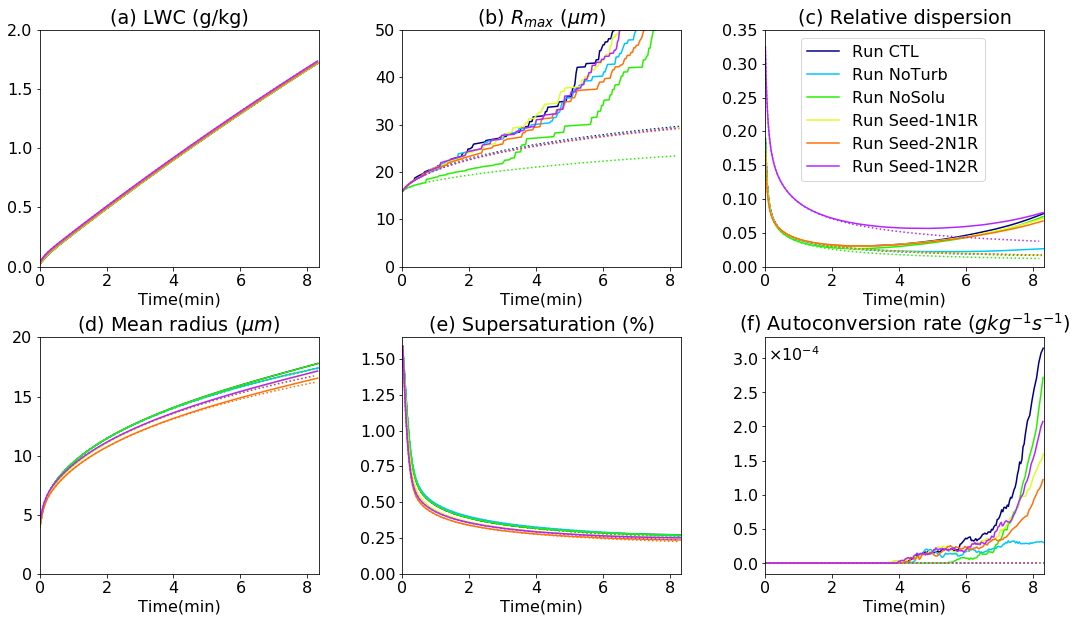

In [3]:
#plot nc file
iplotsource=2; #1=from data above; #2=from ncfiles
#setup plot layout
plt.clf()
fig1,ax1=plt.subplots(2,3,figsize=(18, 10))
ncolor=7#len(N_seed)*len(r_seed)
#color_new = mpl.cm.get_cmap('jet', ncolor)
color_new=plt.cm.gist_rainbow(np.linspace(0,1,ncolor))#gist_rainbow#brg
n=0
#import droplet data
figtag=['Run CTL','Run NoTurb','Run NoSolu','Run Seed-1N1R','Run Seed-2N1R','Run Seed-1N2R']
time_limit=500
selectcase=range(6)
ncolor=7#len(N_seed)*len(r_seed)
#color_new = mpl.cm.get_cmap('jet', ncolor)
color_new=plt.cm.gist_ncar(np.linspace(0,1,ncolor))#gist_rainbow#brg
#color_new=plt.cm.jet(np.linspace(0,1,ncolor))#nipy_spectral
plt.rc('font', size=16)
if iplotsource == 2:
    ncfilename_cc='droplet_timeseries_new.nc'
    #ncfilename_rmin='droplet_timeseries.nc'
    ncfilename_cond='droplet_timeseries_cond.nc'
    dropfh = Dataset(ncfilename_cc,mode='r')
    dropfh_cond=Dataset(ncfilename_cond,mode='r')
    Timeseries_cond=dropfh_cond.variables['TIMES'][:].data
    Timeseries= dropfh.variables['TIMES'][:].data
    rmax_series = dropfh.variables['rmax'][:].data
    lwc_series = dropfh.variables['lwc'][:].data
    rmean_series = dropfh.variables['rmean'][:].data
    disp_series = dropfh.variables['disp'][:].data
    sp_series = dropfh.variables['sp'][:].data
    
    dispcond_series=dropfh_cond.variables['disp'][:].data
    rmax_series_cond = dropfh_cond.variables['rmax'][:].data
    lwc_series_cond = dropfh_cond.variables['lwc'][:].data
    rmean_series_cond = dropfh_cond.variables['rmean'][:].data
    
    auto_conversion30_cond= dropfh_cond.variables['autoconv30'][:].data
    
    sp_series_cond = dropfh_cond.variables['sp'][:].data
    auto_conversion20= dropfh.variables['autoconv20'][:].data
    auto_conversion25= dropfh.variables['autoconv25'][:].data
    auto_conversion30= dropfh.variables['autoconv30'][:].data
    auto_conversion35= dropfh.variables['autoconv35'][:].data
    auto_conversion40= dropfh.variables['autoconv40'][:].data

for (iseedcase,itag) in zip(selectcase,figtag):
    figlabel=str(itag)
    ax1[0,0].plot(Timeseries[:,iseedcase]/60, lwc_series[:,iseedcase]*1e3,label=figlabel,color=color_new[n])
    ax1[0,0].plot(Timeseries_cond[:,iseedcase]/60, lwc_series_cond[:,iseedcase]*1e3, ':',color=color_new[n])
        
    #ax1[0,1].plot(Timeseries[:,iseedcase]/60, rmin_series[:,iseedcase]*1e6,label=figlabel, color=color_new[n])
    ax1[0,1].plot(Timeseries[:,iseedcase]/60, rmax_series[:,iseedcase]*1e6,label=figlabel, color=color_new[n])
    
    #ax1[0,1].plot(Timeseries_cond[:,iseedcase]/60, rmin_series_cond[:,iseedcase]*1e6, ':', color=color_new[n])
    ax1[0,1].plot(Timeseries_cond[:,iseedcase]/60, rmax_series_cond[:,iseedcase]*1e6, ':', color=color_new[n])
    
    ax1[0,2].plot(Timeseries_cond[:,iseedcase]/60, dispcond_series[:,iseedcase], ':',color=color_new[n])
    ax1[0,2].plot(Timeseries[:,iseedcase]/60, disp_series[:,iseedcase], label=figlabel,color=color_new[n])#mean radius not volume mean radius
    
    ax1[1,0].plot(Timeseries[:,iseedcase]/60, rmean_series[:,iseedcase]*1e6,label=figlabel, color=color_new[n])#mean radius
    ax1[1,1].plot(Timeseries[:,iseedcase]/60, sp_series[:,iseedcase]*1e2,label=figlabel,color=color_new[n])
    ax1[1,2].plot(Timeseries[:,iseedcase]/60, auto_conversion30[:,iseedcase]*1e3,label=figlabel,color=color_new[n])
    
    ax1[1,0].plot(Timeseries_cond[:,iseedcase]/60, rmean_series_cond[:,iseedcase]*1e6, ':', color=color_new[n])#mean radius
    ax1[1,1].plot(Timeseries_cond[:,iseedcase]/60, sp_series_cond[:,iseedcase]*1e2, ':',color=color_new[n])
    ax1[1,2].plot(Timeseries_cond[:,iseedcase]/60, auto_conversion30_cond[:,iseedcase]*1e3, ':',color=color_new[n])
    n=n+1
ax1[0,2].legend(loc='upper left',bbox_to_anchor=(0.1, 1))
ax1[0,0].set_title('(a) LWC (g/kg)')
ax1[0,0].set_ylim(0,2.0)
ax1[0,1].set_title('(b) $R_{max}\ (\mu m)$')
ax1[0,1].set_ylim(0,50)
ax1[0,2].set_title('(c) Relative dispersion')
ax1[0,2].set_ylim(0,0.35)
ax1[1,2].set_title('(f) Autoconversion rate $(gkg^{-1}s^{-1})$')
#ax1[1,2].set_ylim(0,0.35e-3)
ax1[1,1].set_title('(e) Supersaturation (%)')
ax1[1,1].set_ylim(0,1.65)
ax1[1,0].set_title('(d) Mean radius ($\mu m$)')
ax1[1,0].set_ylim(0,20)
#ax1[1,2].set_visible(False)
for i in range(3):
    ax1[0,i].set_xlim(0,time_limit/60)
    ax1[1,i].set_xlim(0,time_limit/60)
    ax1[1,i].set_xlabel('Time(min)')
    ax1[0,i].set_xlabel('Time(min)')
ax1[1,2].ticklabel_format(useMathText=True,useOffset=False,axis='y', style='sci', scilimits=(-6,-5))
ax1[1,2].get_yaxis().get_offset_text().set_visible(False)
ax_max = max(ax1[1,2].get_yticks())
exponent_axis = np.floor(np.log10(ax_max)).astype(int)
ax1[1,2].annotate(r'$\times$10$^{%i}$'%(exponent_axis),
             xy=(.01, .9), xycoords='axes fraction')

plt.rc('font', size=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.savefig('Fig_statistics.eps', format='eps')

In [16]:
Timeseries_cond[100:200,1]

array([487.85281372, 492.88546753, 497.91812134,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       